# Uploading and previewing data

In [1]:
!pip install catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.5/98.5 MB 8.1 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import roc_auc_score
from tqdm.notebook import tqdm
from google.colab import drive
from catboost import CatBoostClassifier, Pool
from heapq import nlargest
import random


In [3]:
drive.mount('/content/drive')
# /content/drive/MyDrive/For_project_Recs

Mounted at /content/drive


## downloading res data

In [4]:
res_user = pd.read_csv('/content/drive/MyDrive/Collab/For_project_Recs/Final_data/res_user.csv')
res_post_text = pd.read_csv('/content/drive/MyDrive/Collab/For_project_Recs/Final_data/res_post_text.csv')
df_feed_data = pd.read_csv('/content/drive/MyDrive/Collab/For_project_Recs/Final_data/df_feed_data.csv')
df_feed_data['timestamp'] = pd.to_datetime(df_feed_data['timestamp'])
user_post_like = pd.read_csv('/content/drive/MyDrive/Collab/For_project_Recs/Final_data/user_post_like.csv')

df_feed_user_post_target = pd.read_csv('/content/drive/MyDrive/Collab/For_project_Recs/Final_data/df_feed_user_post_target.csv')

## Look at user data

In [ ]:

# df_user = pd.read_sql(
#     """
#     SELECT * FROM public.user_data;
#     """,

#     con="postgresql://robot-startml-ro:pheiph0hahj1Vaif@"
#         "postgres.lab.karpov.courses:6432/startml"
# )

df_user = pd.read_csv('/content/drive/MyDrive/Collab/For_project_Recs/Row_data/user_data.csv')

In [ ]:
df_user

,user_id,gender,age,country,city,exp_group,os,source
0,200,1,34,Russia,Degtyarsk,3,Android,ads
1,201,0,37,Russia,Abakan,0,Android,ads
2,202,1,17,Russia,Smolensk,4,Android,ads
3,203,0,18,Russia,Moscow,1,iOS,ads
4,204,0,36,Russia,Anzhero-Sudzhensk,3,Android,ads
...,...,...,...,...,...,...,...,...
163200,168548,0,36,Russia,Kaliningrad,4,Android,organic
163201,168549,0,18,Russia,Tula,2,Android,organic
163202,168550,1,41,Russia,Yekaterinburg,4,Android,organic
163203,168551,0,38,Russia,Moscow,3,iOS,organic


In [ ]:
df_user.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 163205 entries, 0 to 163204
Data columns (total 8 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   user_id    163205 non-null  int64 
 1   gender     163205 non-null  int64 
 2   age        163205 non-null  int64 
 3   country    163205 non-null  object
 4   city       163205 non-null  object
 5   exp_group  163205 non-null  int64 
 6   os         163205 non-null  object
 7   source     163205 non-null  object
dtypes: int64(4), object(4)
memory usage: 10.0+ MB


In [ ]:
df_user['country'].value_counts()
print(f"{df_user['country'].value_counts()}\nLength: {len(df_user['country'].value_counts())}")

Russia         143035
Ukraine          8273
Belarus          3293
Kazakhstan       3172
Turkey           1606
Finland          1599
Azerbaijan       1542
Estonia           178
Latvia            175
Cyprus            170
Switzerland       162
Name: country, dtype: int64
Length: 11


In [ ]:
city_distr = df_user['city'].value_counts().sort_values(ascending=False)[2:1500]

<BarContainer object of 1498 artists>

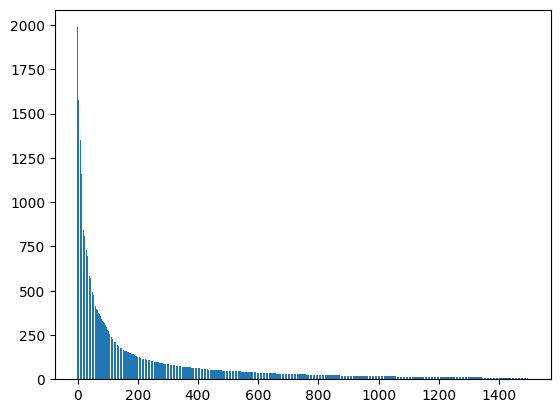

In [ ]:
plt.bar([i for i in range(len(city_distr))],city_distr)

May be need to drop this column, becouse we can't use OHE, and TargetEncodong

In [ ]:
df_user.drop('city', axis=1, inplace=True)

In [ ]:
df_user['source'].value_counts()

ads        101685
organic     61520
Name: source, dtype: int64

In [ ]:
df_user['os'].value_counts()

Android    105972
iOS         57233
Name: os, dtype: int64

In [ ]:
df_user['exp_group'].value_counts()

3    32768
0    32723
1    32638
2    32614
4    32462
Name: exp_group, dtype: int64

In [ ]:
df_user['gender'].value_counts()

1    89980
0    73225
Name: gender, dtype: int64

In [ ]:
df_user.columns

Index(['user_id', 'gender', 'age', 'country', 'exp_group', 'os', 'source'], dtype='object')

In [ ]:
cols_for_ohe = ['gender', 'country', 'exp_group', 'os','source']
X = df_user[cols_for_ohe]


In [ ]:
OHE = OneHotEncoder(drop='first')
X_trans = OHE.fit_transform(X).toarray()

In [ ]:
col_names = OHE.get_feature_names_out()

In [ ]:
OHE_user = pd.DataFrame(X_trans, columns = col_names)

In [ ]:
OHE_user = OHE_user.astype(int)

In [ ]:
res_user = pd.concat([df_user['user_id'], df_user['age'], OHE_user], axis=1)

In [ ]:
res_user

,user_id,age,gender_1,country_Belarus,country_Cyprus,country_Estonia,country_Finland,country_Kazakhstan,country_Latvia,country_Russia,country_Switzerland,country_Turkey,country_Ukraine,exp_group_1,exp_group_2,exp_group_3,exp_group_4,os_iOS,source_organic
0,200,34,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0
1,201,37,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
2,202,17,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0
3,203,18,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0
4,204,36,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
163200,168548,36,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1
163201,168549,18,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1
163202,168550,41,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1
163203,168551,38,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,1


In [ ]:
res_user.to_csv('/content/drive/MyDrive/Collab/For_project_Recs/Final_data/res_user.csv', index=False)

## Look at posts

In [36]:
# df_post_text = pd.read_sql(
#     """
#     SELECT * FROM public.post_text_df;
#     """,

#     con="postgresql://robot-startml-ro:pheiph0hahj1Vaif@"
#         "postgres.lab.karpov.courses:6432/startml"
# )


df_post_text = pd.read_csv('/content/drive/MyDrive/Collab/For_project_Recs/Row_data/df_post_text.csv')

In [5]:
df_post_text['topic'].value_counts()

movie            3000
covid            1799
business          510
sport             510
politics          417
tech              401
entertainment     386
Name: topic, dtype: int64

In [6]:
df_post_text

,post_id,text,topic
0,1,UK economy facing major risks\n\nThe UK manufa...,business
1,2,Aids and climate top Davos agenda\n\nClimate c...,business
2,3,Asian quake hits European shares\n\nShares in ...,business
3,4,India power shares jump on debut\n\nShares in ...,business
4,5,Lacroix label bought by US firm\n\nLuxury good...,business
...,...,...,...
7018,7315,"OK, I would not normally watch a Farrelly brot...",movie
7019,7316,I give this movie 2 stars purely because of it...,movie
7020,7317,I cant believe this film was allowed to be mad...,movie
7021,7318,The version I saw of this film was the Blockbu...,movie


In [37]:
len_text = df_post_text['text'].apply(lambda x: len(x))
print(len_text)

0       1967
1       2701
2       3408
3       1026
4        889
        ... 
7018     803
7019     800
7020     636
7021     728
7022     790
Name: text, Length: 7023, dtype: int64


In [38]:
df_post_text['len_text'] = len_text



In [40]:
df_post_text.to_csv('/content/drive/MyDrive/Collab/For_project_Recs/Final_data/res_post_text.csv', index=False)

Need OHE coding for topic and also using TFIDF to text  OR use catboost with

In [10]:
# # TFIDF coder for text

# def tfidf_vectorization(dataset: pd.DataFrame, to_vector: str):
#     tfidf = TfidfVectorizer()
#     tfidf_matrix = tfidf.fit_transform(dataset[to_vector])

#     max_tfidf_values = tfidf_matrix.max(axis=1).toarray().flatten()
#     avg_tfidf_values = np.ravel(tfidf_matrix.mean(axis=1).flatten())

#     dataset['max_tfidf'] = max_tfidf_values
#     # dataset['avg_tfidf'] = avg_tfidf_values

#     return dataset
# tmp = tfidf_vectorization(df_post_text, to_vector = 'text')
# res_post_text = tmp.drop('text', axis=1).copy()


In [11]:
# res_post_text

,post_id,topic,len_text,max_tfidf
0,1,business,1967,0.439495
1,2,business,2701,0.290946
2,3,business,3408,0.279045
3,4,business,1026,0.525321
4,5,business,889,0.409826
...,...,...,...,...
7018,7315,movie,803,0.226524
7019,7316,movie,800,0.333130
7020,7317,movie,636,0.507582
7021,7318,movie,728,0.263741


In [12]:
# res_post_text.to_csv('/content/drive/MyDrive/Collab/For_project_Recs/Final_data/res_post_text.csv', index=False)

## Now feed_data

In [ ]:
# df_feed_data = pd.read_sql(
#     """
#     SELECT * FROM public.feed_data LIMIT 5000000;
#     """,

#     con="postgresql://robot-startml-ro:pheiph0hahj1Vaif@"
#         "postgres.lab.karpov.courses:6432/startml"
# )

df_feed_data = pd.read_csv('/content/drive/MyDrive/Collab/For_project_Recs/Row_data/df_feed_data.csv')

In [ ]:
df_feed_data.shape

(5000000, 5)

In [ ]:
df_feed_data

,timestamp,user_id,post_id,action,target
0,2021-12-18 19:21:00,90582,2320,view,0
1,2021-12-18 19:23:55,90582,4534,view,0
2,2021-12-18 19:26:33,90582,2790,view,0
3,2021-12-18 19:28:50,90582,4908,view,0
4,2021-12-18 19:30:33,90582,5729,view,0
...,...,...,...,...,...
4999995,2021-12-15 20:18:10,6545,3952,like,0
4999996,2021-12-15 20:18:12,6545,3132,view,0
4999997,2021-12-15 20:19:02,6545,1430,view,1
4999998,2021-12-15 20:21:10,6545,1430,like,0


In [ ]:
df_feed_data[(df_feed_data['action'] == 'like') | (df_feed_data['target'] == 1)]

,timestamp,user_id,post_id,action,target
10,2021-12-19 11:25:01,90582,1867,view,1
11,2021-12-19 11:26:40,90582,1867,like,0
18,2021-12-19 11:38:44,90582,6117,view,1
19,2021-12-19 11:39:44,90582,6117,like,0
22,2021-12-19 11:45:13,90582,5537,view,1
...,...,...,...,...,...
4999994,2021-12-15 20:15:55,6545,3952,view,1
4999995,2021-12-15 20:18:10,6545,3952,like,0
4999997,2021-12-15 20:19:02,6545,1430,view,1
4999998,2021-12-15 20:21:10,6545,1430,like,0


In [ ]:
# so we can drop all 'likes', becouse we don't have in inference and also it so correlate with items where user and post same, but action different
df_feed_data.drop(df_feed_data[df_feed_data['action'] == 'like'].index, inplace=True)

In [ ]:
len(df_feed_data['post_id'].unique()) # not all posts

6831

In [ ]:
len(df_feed_data['user_id'].unique())# not all users, only 1/16 of all

10644

In [ ]:
df_feed_data.drop('action', axis=1, inplace=True)

#### Let's convert to datetime timstamp
And parse date

In [ ]:
df_feed_data['timestamp'] = pd.to_datetime(df_feed_data['timestamp'])

In [ ]:
def parse_time(time, type_):
    if type_ == 'month':
      return time.month
    if type_ == 'day':
      return time.day
    if type_ == 'hour':
      return time.hour
    if type_ == 'minute':
      return time.minute

def parse_date_time(data):
    data['month'] = data['timestamp'].apply(parse_time, type_='month')
    data['day'] = data['timestamp'].apply(parse_time, type_='day')
    data['hour'] = data['timestamp'].apply(parse_time, type_='hour')
    data['minute'] = data['timestamp'].apply(parse_time, type_='minute')

    data['month'] = data['month'].astype (object)
    data['day'] = data['day'].astype (object)
    data['hour'] = data['hour'].astype (object)
    data['minute'] = data['minute'].astype (object)
    return data


In [ ]:
df_feed_data = parse_date_time(df_feed_data)
# df_feed_data = df_feed_data.drop('timestamp', axis=1)

In [ ]:
df_feed_data

,timestamp,user_id,post_id,target,month,day,hour,minute
0,2021-12-18 19:21:00,90582,2320,0,12,18,19,21
1,2021-12-18 19:23:55,90582,4534,0,12,18,19,23
2,2021-12-18 19:26:33,90582,2790,0,12,18,19,26
3,2021-12-18 19:28:50,90582,4908,0,12,18,19,28
4,2021-12-18 19:30:33,90582,5729,0,12,18,19,30
...,...,...,...,...,...,...,...,...
4999993,2021-12-15 20:14:23,6545,4800,0,12,15,20,14
4999994,2021-12-15 20:15:55,6545,3952,1,12,15,20,15
4999996,2021-12-15 20:18:12,6545,3132,0,12,15,20,18
4999997,2021-12-15 20:19:02,6545,1430,1,12,15,20,19


In [ ]:
df_feed_data = df_feed_data.sort_values('timestamp')

In [ ]:
df_feed_data.reset_index(drop=True, inplace=True)

In [ ]:
df_feed_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4464186 entries, 0 to 4464185
Data columns (total 8 columns):
 #   Column     Dtype         
---  ------     -----         
 0   timestamp  datetime64[ns]
 1   user_id    int64         
 2   post_id    int64         
 3   target     int64         
 4   month      object        
 5   day        object        
 6   hour       object        
 7   minute     object        
dtypes: datetime64[ns](1), int64(3), object(4)
memory usage: 272.5+ MB


In [ ]:
df_feed_data.to_csv('/content/drive/MyDrive/Collab/For_project_Recs/Final_data/df_feed_data.csv', index=False)

### Make filter of posts
This data for training model, also can take data for steps of choosing what posts for specific user we can suggest, and after that give this info to model and make final predict

In [ ]:
df_feed_user_post_target = pd.read_csv('/content/drive/MyDrive/Collab/For_project_Recs/Row_data/df_feed_user_post_target.csv')

In [ ]:
#df_feed_user_post_target = df_feed_user_post_target.iloc[:5000000]

In [ ]:
df_feed_user_post_target['target'] = np.ones(df_feed_user_post_target.shape[0], dtype=int)

In [ ]:
df_feed_user_post_target

,user_id,post_id,target
0,26604,3236,1
1,26604,1864,1
2,26604,19,1
3,26604,1615,1
4,26604,6070,1
...,...,...,...
8206340,26604,5405,1
8206341,26604,5382,1
8206342,26604,5472,1
8206343,26604,5001,1


In [ ]:
len(df_feed_user_post_target['user_id'].unique())

163202

In [ ]:
len(df_feed_user_post_target['post_id'].unique())

6831

Not all posts are liked

So 63671 users we don't have info of likes, becouse we have problem with memory on collab

In [ ]:
user_post_like = df_feed_user_post_target.groupby('user_id')['post_id'].agg(set).reset_index()

In [ ]:
user_post_like

,user_id,post_id
0,200,"{6404, 6661, 6919, 3470, 783, 3089, 668, 6300,..."
1,201,"{129, 4356, 4357, 649, 6026, 3851, 6412, 4363,..."
2,202,"{6657, 3589, 4113, 6675, 2582, 3100, 1567, 259..."
3,203,"{2818, 5379, 2309, 3208, 5769, 3978, 5258, 679..."
4,204,"{3328, 6530, 5386, 1805, 5135, 2579, 2720, 208..."
...,...,...
99529,168548,"{5894, 5517, 655, 1951, 6049, 2738, 4019, 6586..."
99530,168549,"{3969, 2949, 4613, 1803, 2712, 1568, 6051, 107..."
99531,168550,"{4481, 4226, 2691, 7045, 659, 5779, 541, 5790,..."
99532,168551,"{3586, 4098, 6919, 3337, 7057, 3730, 3608, 629..."


In [ ]:
user_post_like.rename(columns = {'post_id':'post_like'}, inplace=True)

In [ ]:
user_post_like.to_csv('/content/drive/MyDrive/Collab/For_project_Recs/Final_data/user_post_like.csv', index=False)

In [ ]:
not_liked_posts = list(set(df_post_text['post_id'].unique()) - set(df_feed_user_post_target['post_id'].unique()))

NameError: name 'df_post_text' is not defined

In [ ]:
len(not_liked_posts)

192

In [ ]:
user_target_likes_posts.values

array([{4994, 4, 5765, 7046, 383, 6152, 2439, 522, 5899, 14, 3983, 5904, 6670, 3219, 1684, 5397, 2328, 4766, 4002, 6820, 4902, 4397, 2862, 7087, 5296, 7216, 2351, 7085, 5042, 53, 2103, 6968, 4409, 6714, 3389, 3262, 5183, 3135, 6979, 7107, 2759, 6728, 5323, 5454, 3791, 2897, 4053, 6102, 4568, 2778, 1756, 3036, 3805, 3682, 3427, 6116, 1125, 3939, 4708, 4200, 4841, 1771, 1004, 1900, 2798, 3821, 1775, 3052, 499, 6901, 5621, 1398, 3830, 6266, 3324, 7167}],
      dtype=object)

In [ ]:
user_target = 249
user_target_likes_posts = user_post_like.loc[user_target, "post_like"]

all_posts = set(res_post_text['post_id'].unique())
not_liked_before = (all_posts - user_target_likes_posts)

7022

### function find_neighb

In [ ]:

def find_neighb(user_target, user_post_like, not_liked_posts,  NUMBER_OF_REC=50):
    NUMBER_OF_NEIGHB = 100
    SMALLEST_NUMBER_OF_INTER = 10
    list_neighb = []
    user_check = set()

    user_target_likes_posts = user_post_like.loc[user_target, "post_like"]
    # can be before
    all_posts = set(res_post_text['post_id'].unique())
    not_liked_before = (all_posts - user_target_likes_posts)
    ### should think about posts which user have been viewed, but not liked



    # choice random users for next check
    while len(user_check) < NUMBER_OF_NEIGHB:
        x = random.choice(user_post_like.index)
        if x not in user_check:
            user_check.add(x)

    # There we will know how close user_1 to usr in user_check
    for user_1 in user_check:
        list_neighb.append(
            (
                len(
                    user_post_like.loc[user_target, "post_id"]
                    & user_post_like.loc[user_1, "post_id"]
                ),
                user_1,
            )
        )
    # if they intersection is small it is good. Take
    res_nearest = nlargest(SMALLEST_NUMBER_OF_INTER, list_neighb, key=lambda x: x[0])
    res_recom_posts = set()
    count = 0
    for _, neighb in res_nearest:
        # user targ not liked but can be interested
        post = (
            user_post_like.loc[neighb, "post_id"]
            - user_post_like.loc[user_target, "post_id"]
        ).pop()
        if post not in res_recom_posts and post in not_liked_before:
            res_recom_posts.add(post)
            count += 1
        if count >= NUMBER_OF_REC:
            return res_recom_posts

    # count < NUMBER_OF_REC take not liked posts
    while count < NUMBER_OF_REC:

        post_not_liked = random.choice(not_liked_posts)
        if post_not_liked not in res_recom_posts:
            res_recom_posts.add(post_not_liked)
            count += 1

    return res_recom_posts



In [ ]:
%%time
for i in range(5):
    user = user_post_like.index[i]
    %time res = find_neighb(user,user_post_like, not_liked_posts)
    res

CPU times: user 5.52 ms, sys: 18 µs, total: 5.54 ms
Wall time: 9.11 ms
CPU times: user 4.39 ms, sys: 0 ns, total: 4.39 ms
Wall time: 4.41 ms
CPU times: user 4.87 ms, sys: 0 ns, total: 4.87 ms
Wall time: 4.89 ms
CPU times: user 4.7 ms, sys: 0 ns, total: 4.7 ms
Wall time: 4.89 ms
CPU times: user 4.27 ms, sys: 670 µs, total: 4.94 ms
Wall time: 4.96 ms
CPU times: user 34.8 ms, sys: 1.01 ms, total: 35.8 ms
Wall time: 39.7 ms


In [ ]:
df_feed_user_post_target.to_csv('/content/drive/MyDrive/Collab/For_project_Recs/Final_data/df_feed_user_post_target.csv', index=False)

## Content way

In [18]:
res_user

,user_id,age,gender_1,country_Belarus,country_Cyprus,country_Estonia,country_Finland,country_Kazakhstan,country_Latvia,country_Russia,country_Switzerland,country_Turkey,country_Ukraine,exp_group_1,exp_group_2,exp_group_3,exp_group_4,os_iOS,source_organic
0,200,34,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0
1,201,37,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
2,202,17,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0
3,203,18,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0
4,204,36,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
163200,168548,36,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1
163201,168549,18,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1
163202,168550,41,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1
163203,168551,38,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,1


In [19]:
res_post_text

,post_id,topic,len_text,max_tfidf
0,1,business,1967,0.439495
1,2,business,2701,0.290946
2,3,business,3408,0.279045
3,4,business,1026,0.525321
4,5,business,889,0.409826
...,...,...,...,...
7018,7315,movie,803,0.226524
7019,7316,movie,800,0.333130
7020,7317,movie,636,0.507582
7021,7318,movie,728,0.263741


In [20]:
df_feed_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4464186 entries, 0 to 4464185
Data columns (total 8 columns):
 #   Column     Dtype         
---  ------     -----         
 0   timestamp  datetime64[ns]
 1   user_id    int64         
 2   post_id    int64         
 3   target     int64         
 4   month      int64         
 5   day        int64         
 6   hour       int64         
 7   minute     int64         
dtypes: datetime64[ns](1), int64(7)
memory usage: 272.5 MB


In [5]:
data = df_feed_data.merge(res_user, on='user_id', how='left')
data

,timestamp,user_id,post_id,target,month,day,hour,minute,age,gender_1,...,country_Russia,country_Switzerland,country_Turkey,country_Ukraine,exp_group_1,exp_group_2,exp_group_3,exp_group_4,os_iOS,source_organic
0,2021-10-01 06:05:25,6357,6218,0,10,1,6,5,24,1,...,1,0,0,0,0,0,1,0,0,0
1,2021-10-01 06:05:25,91774,5961,0,10,1,6,5,18,1,...,1,0,0,0,0,0,1,0,0,0
2,2021-10-01 06:06:45,139714,2360,0,10,1,6,6,35,0,...,0,0,0,0,0,1,0,0,1,1
3,2021-10-01 06:06:45,126114,1629,0,10,1,6,6,21,0,...,1,0,0,0,0,1,0,0,0,1
4,2021-10-01 06:06:45,146517,733,0,10,1,6,6,26,1,...,1,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4464181,2021-12-29 23:43:27,118764,6506,0,12,29,23,43,22,1,...,1,0,0,0,0,0,0,0,0,1
4464182,2021-12-29 23:43:55,91962,1428,0,12,29,23,43,35,1,...,1,0,0,0,0,1,0,0,0,0
4464183,2021-12-29 23:45:27,91962,1671,0,12,29,23,45,35,1,...,1,0,0,0,0,1,0,0,0,0
4464184,2021-12-29 23:48:26,91962,2284,0,12,29,23,48,35,1,...,1,0,0,0,0,1,0,0,0,0


In [6]:
data = data.merge(res_post_text, on='post_id', how='left')
# data.drop('timestamp', axis=1, inplace=True)

In [7]:
train_data = data[:4000000]
test_data = data[4000000:]

train_target = train_data['target']
train_data = train_data.drop(['target', 'user_id', 'post_id'], axis=1)

test_target = test_data['target']
test_data = test_data.drop(['target', 'user_id', 'post_id'], axis=1)

print(train_data.shape, test_data.shape)

(4000000, 26) (464186, 26)


In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4464186 entries, 0 to 4464185
Data columns (total 29 columns):
 #   Column               Dtype         
---  ------               -----         
 0   timestamp            datetime64[ns]
 1   user_id              int64         
 2   post_id              int64         
 3   target               int64         
 4   month                int64         
 5   day                  int64         
 6   hour                 int64         
 7   minute               int64         
 8   age                  int64         
 9   gender_1             int64         
 10  country_Belarus      int64         
 11  country_Cyprus       int64         
 12  country_Estonia      int64         
 13  country_Finland      int64         
 14  country_Kazakhstan   int64         
 15  country_Latvia       int64         
 16  country_Russia       int64         
 17  country_Switzerland  int64         
 18  country_Turkey       int64         
 19  country_Ukraine      

### Now we have data for model



### Train catboost

TRY DROP TIME AND USE TIMESTAMP

In [9]:
tmp = data.drop(['month', 'day',	'hour',	'minute'], axis=1)


In [10]:
tmp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4464186 entries, 0 to 4464185
Data columns (total 25 columns):
 #   Column               Dtype         
---  ------               -----         
 0   timestamp            datetime64[ns]
 1   user_id              int64         
 2   post_id              int64         
 3   target               int64         
 4   age                  int64         
 5   gender_1             int64         
 6   country_Belarus      int64         
 7   country_Cyprus       int64         
 8   country_Estonia      int64         
 9   country_Finland      int64         
 10  country_Kazakhstan   int64         
 11  country_Latvia       int64         
 12  country_Russia       int64         
 13  country_Switzerland  int64         
 14  country_Turkey       int64         
 15  country_Ukraine      int64         
 16  exp_group_1          int64         
 17  exp_group_2          int64         
 18  exp_group_3          int64         
 19  exp_group_4          

In [11]:
START = tmp['timestamp'][0]

tmp['time_delta'] = tmp['timestamp'].apply(lambda x: (x - START).days)

In [12]:
tmp.drop('timestamp', axis=1, inplace=True)

In [13]:
train_data = tmp[:4000000]
test_data = tmp[4000000:]

train_target = train_data['target']
train_data = train_data.drop(['target', 'user_id', 'post_id'], axis=1)

test_target = test_data['target']
test_data = test_data.drop(['target', 'user_id', 'post_id'], axis=1)

print(train_data.shape, test_data.shape)

(4000000, 22) (464186, 22)


In [ ]:
train_data

,age,gender_1,country_Belarus,country_Cyprus,country_Estonia,country_Finland,country_Kazakhstan,country_Latvia,country_Russia,country_Switzerland,...,exp_group_1,exp_group_2,exp_group_3,exp_group_4,os_iOS,source_organic,topic,len_text,max_tfidf,time_delta
0,24,1,0,0,0,0,0,0,1,0,...,0,0,1,0,0,0,movie,734,0.394446,0
1,18,1,0,0,0,0,0,0,1,0,...,0,0,1,0,0,0,movie,1223,0.330207,0
2,35,0,1,0,0,0,0,0,0,0,...,0,1,0,0,1,1,covid,140,0.459939,0
3,21,0,0,0,0,0,0,0,1,0,...,0,1,0,0,0,1,sport,2890,0.357309,0
4,26,1,0,0,0,0,0,0,1,0,...,0,0,0,0,0,1,entertainment,1329,0.326534,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3999995,20,1,0,0,0,0,0,0,1,0,...,0,1,0,0,0,0,covid,134,0.351413,80
3999996,17,1,0,0,0,0,0,0,0,0,...,0,1,0,0,1,0,tech,1977,0.251988,80
3999997,30,1,0,0,0,0,0,0,1,0,...,1,0,0,0,0,1,business,1410,0.420508,80
3999998,35,1,0,0,0,0,0,0,1,0,...,0,0,0,0,1,0,politics,1689,0.388302,80


In [14]:

cat_features = ['topic']
catboost_pool = Pool(train_data, train_target, cat_features=cat_features)


task_type="GPU",
model_test = CatBoostClassifier(iterations=500,
                                    learning_rate=0.02,
                                    task_type="GPU",
                                    cat_features=cat_features,
                                    verbose=50)



model_test.fit(catboost_pool)

# catboost_model.save_model('/content/drive/MyDrive/For_project_Recs/catboost_model',
#                            format="cbm")

# catboost_model = CatBoostClassifier()  # здесь не указываем параметры, которые были при обучении, в дампе модели все есть

# catboost_model.load_model("/content/drive/MyDrive/For_project_Recs/catboost_model")


0:	learn: 0.6774012	total: 220ms	remaining: 1m 49s
50:	learn: 0.3886882	total: 9.52s	remaining: 1m 23s
100:	learn: 0.3587326	total: 18.3s	remaining: 1m 12s
150:	learn: 0.3543304	total: 27.1s	remaining: 1m 2s
200:	learn: 0.3531113	total: 37.1s	remaining: 55.2s
250:	learn: 0.3522051	total: 46s	remaining: 45.6s
300:	learn: 0.3516413	total: 54.9s	remaining: 36.3s
350:	learn: 0.3511549	total: 1m 3s	remaining: 27.1s
400:	learn: 0.3508842	total: 1m 12s	remaining: 17.9s
450:	learn: 0.3506831	total: 1m 21s	remaining: 8.85s
499:	learn: 0.3505187	total: 1m 31s	remaining: 0us


In [15]:
roc_auc_score(test_target, model_test.predict_proba(test_data)[:, 1])

0.6133553477527748

In [16]:
model_test.score(test_data, test_target)

0.8604740341156347

### Download and load model

In [17]:
model_test.save_model('./catboost_model_500',format="cbm")

# catboost_model = CatBoostClassifier()  # здесь не указываем параметры, которые были при обучении, в дампе модели все есть

# catboost_model.load_model("/content/drive/MyDrive/Collab/For_project_Recs/catboost_model")

In [ ]:
col_to_drop = pd.DataFrame({'feature_importance': model_test.get_feature_importance(),
              'feature_names': train_data.columns}).sort_values(by=['feature_importance'],
                                                           ascending=False)['feature_names'][10:].values

### try remove bad features

In [31]:
col_to_drop

array(['exp_group_3', 'country_Turkey', 'country_Belarus', 'max_tfidf',
       'country_Kazakhstan', 'country_Finland', 'country_Switzerland',
       'country_Latvia', 'source_organic', 'os_iOS', 'country_Cyprus',
       'country_Estonia'], dtype=object)

In [25]:
tmp.drop(col_to_drop, axis=1, inplace=True)

In [26]:
train_data = tmp[:4000000]
test_data = tmp[4000000:]

train_target = train_data['target']
train_data = train_data.drop(['target', 'user_id', 'post_id'], axis=1)

test_target = test_data['target']
test_data = test_data.drop(['target', 'user_id', 'post_id'], axis=1)

print(train_data.shape, test_data.shape)

(4000000, 10) (464186, 10)


In [32]:

cat_features = ['topic']
catboost_pool = Pool(train_data, train_target, cat_features=cat_features)


task_type="GPU",
model_test = CatBoostClassifier(iterations=250,
                                    learning_rate=0.02,
                                    task_type="GPU",
                                    cat_features=cat_features,
                                    verbose=50)



model_test.fit(catboost_pool)

# catboost_model.save_model('/content/drive/MyDrive/For_project_Recs/catboost_model',
#                            format="cbm")

# catboost_model = CatBoostClassifier()  # здесь не указываем параметры, которые были при обучении, в дампе модели все есть

# catboost_model.load_model("/content/drive/MyDrive/For_project_Recs/catboost_model")


0:	learn: 0.6773614	total: 374ms	remaining: 1m 33s
50:	learn: 0.3885537	total: 13.3s	remaining: 52s
100:	learn: 0.3587888	total: 22.4s	remaining: 33.1s
150:	learn: 0.3538946	total: 31.9s	remaining: 20.9s
200:	learn: 0.3527314	total: 40.6s	remaining: 9.89s
249:	learn: 0.3518864	total: 50s	remaining: 0us


In [33]:
roc_auc_score(test_target, model_test.predict_proba(test_data)[:, 1])

0.6079167978882661

In [34]:
model_test.score(test_data, test_target)

0.8604740341156347

In [35]:
model_test.save_model('./catboost_model_250_remove_col',format="cbm")


# Let's try connect model and find_neighb function

In [ ]:
user_post_like_set_ind = user_post_like.set_index('user_id')

In [ ]:
test_user_id = 2134
NUMBER_OF_REC = 50
#possible_posts = list(find_neighb(test_user_id, user_post_like_set_ind, not_liked_posts, NUMBER_OF_REC))
possible_posts = [i for i in range(100,150)]
# user_to_concat = res_user[res_user['user_id']== test_user_id]
# user_to_concat = user_to_concat.loc[user_to_concat.index.repeat(NUMBER_OF_REC)].reset_index(drop=True)


pair_user_posts = np.array([[test_user_id] * NUMBER_OF_REC , possible_posts]).T
pair_user_posts = pd.DataFrame(pair_user_posts, columns=['user_id', 'post_id'])
pair_user_posts = pair_user_posts.merge(res_user, on='user_id', how='left').merge(res_post_text, on='post_id', how='left')

In [ ]:
%%time

test_user_id = 2134
NUMBER_OF_REC = 50
possible_posts = list(find_neighb(test_user_id, user_post_like_set_ind, not_liked_posts, NUMBER_OF_REC))

user_to_concat = res_user[res_user['user_id']== test_user_id]
user_to_concat = user_to_concat.loc[user_to_concat.index.repeat(NUMBER_OF_REC)].reset_index(drop=True)

index_res = []
for post in possible_posts:
index_res.append(res_post_text[res_post_text['post_id'] == post].index[0])
posts_to_concat = res_post_text.loc[index_res].reset_index(drop=True)
data_to_model = pd.concat([user_to_concat, posts_to_concat], axis=1)
# обработать время
data_to_model['time_delta']=[80] * NUMBER_OF_REC
##################
data_to_model = data_to_model.drop(['user_id', 'post_id'], axis=1)
predict_model = catboost_model.predict_proba(data_to_model).tolist()
for i in range(len(predict_model)):
    predict_model[i][0] = possible_posts[i]
predict_model.sort(reverse=True,key=(lambda x: x[1]))
result_rec = []
for preds in predict_model[:5]:
    result_rec.append(preds[0])


CPU times: user 46.5 ms, sys: 0 ns, total: 46.5 ms
Wall time: 104 ms


In [ ]:
result_rec

[2202, 1965, 432, 1919, 2089]

In inference we suggest that the time will be like the last time in our data, so timestamp will be 80

In [ ]:
data_to_model.head()

,age,gender_1,country_Belarus,country_Cyprus,country_Estonia,country_Finland,country_Kazakhstan,country_Latvia,country_Russia,country_Switzerland,...,exp_group_1,exp_group_2,exp_group_3,exp_group_4,os_iOS,source_organic,topic,len_text,max_tfidf,time_delta
0,34,1,0,0,0,0,0,0,1,0,...,0,0,1,0,0,0,covid,127,0.490978,80
1,34,1,0,0,0,0,0,0,1,0,...,0,0,1,0,0,0,movie,1377,0.245286,80
2,34,1,0,0,0,0,0,0,1,0,...,0,0,1,0,0,0,movie,628,0.262917,80
3,34,1,0,0,0,0,0,0,1,0,...,0,0,1,0,0,0,movie,202,0.439834,80
4,34,1,0,0,0,0,0,0,1,0,...,0,0,1,0,0,0,business,3361,0.339201,80


[[5249, 0.16281323259608102],
 [5505, 0.1592115723103366],
 [4611, 0.15646782318934963],
 [4224, 0.1505999413967938],
 [3609, 0.13633568455216408]]

-------------------------------------

# Let's move to next step with making supporting table in database

In [ ]:
user_post_like

,user_id,post_like
0,200,"{6404, 6661, 6919, 3470, 783, 3089, 668, 6300,..."
1,201,"{129, 4356, 4357, 649, 6026, 3851, 6412, 4363,..."
2,202,"{6657, 3589, 4113, 6675, 2582, 3100, 1567, 259..."
3,203,"{2818, 5379, 2309, 3208, 5769, 3978, 5258, 679..."
4,204,"{3328, 6530, 5386, 1805, 5135, 2579, 2720, 208..."
...,...,...
163197,168548,"{5894, 5517, 655, 1951, 6049, 2738, 4019, 6586..."
163198,168549,"{3969, 2949, 4613, 1803, 2712, 1568, 6051, 107..."
163199,168550,"{4481, 4226, 2691, 7045, 659, 5779, 541, 5790,..."
163200,168551,"{3586, 4098, 6919, 3337, 7057, 3730, 3608, 629..."


In [ ]:
res_user = res_user.merge(user_post_like, on='user_id', how='left')

In [ ]:
type(res_user['post_like'][1])

str

In [ ]:
res_user

,user_id,age,gender_1,country_Belarus,country_Cyprus,country_Estonia,country_Finland,country_Kazakhstan,country_Latvia,country_Russia,country_Switzerland,country_Turkey,country_Ukraine,exp_group_1,exp_group_2,exp_group_3,exp_group_4,os_iOS,source_organic,post_like
0,200,34,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,"{6404, 6661, 6919, 3470, 783, 3089, 668, 6300,..."
1,201,37,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,"{129, 4356, 4357, 649, 6026, 3851, 6412, 4363,..."
2,202,17,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,"{6657, 3589, 4113, 6675, 2582, 3100, 1567, 259..."
3,203,18,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,"{2818, 5379, 2309, 3208, 5769, 3978, 5258, 679..."
4,204,36,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,"{3328, 6530, 5386, 1805, 5135, 2579, 2720, 208..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
163200,168548,36,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,"{5894, 5517, 655, 1951, 6049, 2738, 4019, 6586..."
163201,168549,18,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,"{3969, 2949, 4613, 1803, 2712, 1568, 6051, 107..."
163202,168550,41,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,"{4481, 4226, 2691, 7045, 659, 5779, 541, 5790,..."
163203,168551,38,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,1,"{3586, 4098, 6919, 3337, 7057, 3730, 3608, 629..."


Fill na with most liked posts

In [ ]:
df_feed_user_post_target.head()

,user_id,post_id,target
0,26604,3236,1
1,26604,1864,1
2,26604,19,1
3,26604,1615,1
4,26604,6070,1


In [ ]:
most_liked = set(df_feed_user_post_target.groupby('post_id')['post_id'].count().sort_values()[-20:].index.values)

In [ ]:
res_user[res_user['user_id'] == 52233]['post_like']

48539    NaN
Name: post_like, dtype: object

In [ ]:
index_nan = res_user.loc[pd.isna(res_user["post_like"]), :].index

In [ ]:
for ind in index_nan:
    res_user.at[ind,'post_like'] = most_liked

### Upload res_user in database

In [ ]:
!pip install sqlalchemy

In [ ]:
import pandas as pd
from sqlalchemy import create_engine

engine = create_engine(
    "postgresql://robot-startml-ro:pheiph0hahj1Vaif@"
    "postgres.lab.karpov.courses:6432/startml"
)

res_user.to_sql('ale_kim_features_res_user_last', con=engine, index=False) # записываем таблицу



205

In [ ]:
import pandas as pd
from sqlalchemy import create_engine, text


def batch_load_sql(query: str) -> pd.DataFrame:
    CHUNKSIZE = 200000
    engine = create_engine(
        "postgresql://robot-startml-ro:pheiph0hahj1Vaif@"
        "postgres.lab.karpov.courses:6432/startml"
    )
    conn = engine.connect().execution_options(stream_results=True)
    chunks = []
    for chunk_dataframe in pd.read_sql(text(query), conn, chunksize=CHUNKSIZE):
        chunks.append(chunk_dataframe)
    conn.close()
    return pd.concat(chunks, ignore_index=True)


def load_features() -> pd.DataFrame:
    return batch_load_sql('SELECT * FROM ale_kim_features_res_user_last')


In [ ]:
df = load_features()

In [ ]:
df

,user_id,age,gender_1,country_Belarus,country_Cyprus,country_Estonia,country_Finland,country_Kazakhstan,country_Latvia,country_Russia,country_Switzerland,country_Turkey,country_Ukraine,exp_group_1,exp_group_2,exp_group_3,exp_group_4,os_iOS,source_organic
0,200,34,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0
1,201,37,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
2,202,17,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0
3,203,18,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0
4,204,36,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
163200,168548,36,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1
163201,168549,18,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1
163202,168550,41,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1
163203,168551,38,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,1


# test another idea


In [5]:
res_post_text

,post_id,topic,len_text,max_tfidf
0,1,business,1967,0.439495
1,2,business,2701,0.290946
2,3,business,3408,0.279045
3,4,business,1026,0.525321
4,5,business,889,0.409826
...,...,...,...,...
7018,7315,movie,803,0.226524
7019,7316,movie,800,0.333130
7020,7317,movie,636,0.507582
7021,7318,movie,728,0.263741


In [6]:
res_user

,user_id,age,gender_1,country_Belarus,country_Cyprus,country_Estonia,country_Finland,country_Kazakhstan,country_Latvia,country_Russia,country_Switzerland,country_Turkey,country_Ukraine,exp_group_1,exp_group_2,exp_group_3,exp_group_4,os_iOS,source_organic
0,200,34,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0
1,201,37,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
2,202,17,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0
3,203,18,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0
4,204,36,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
163200,168548,36,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1
163201,168549,18,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1
163202,168550,41,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1
163203,168551,38,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,1


In [14]:
time_diff = 82

In [16]:
pair_user_posts = np.array([[200] * len(res_post_text['post_id'].unique()), res_post_text['post_id'].unique()]).T
pair_user_posts = pd.DataFrame(pair_user_posts, columns=["user_id", "post_id"])
data_to_model = pair_user_posts.merge(res_user, on="user_id", how="left").merge(
    res_post_text, on="post_id", how="left"
)
time_delta = np.array([time_diff] * len(res_post_text['post_id'].unique()))
data_to_model.columns
data_to_model.insert(len(data_to_model.columns), "time_delta", time_delta)
data_to_model = data_to_model.drop(['user_id',	'post_id'], axis=1)
predict_model = catboost_model.predict_proba(data_to_model).tolist()
for i in range(len(predict_model)):
    predict_model[i][0] = res_post_text['post_id'].unique()[i]
predict_model.sort(reverse=True, key=(lambda x: x[1]))
result_rec = []
for preds in predict_model[:5]:
    result_rec.append(preds[0])



In [23]:
result_rec

[5812, 4651, 6628, 4594, 6375]